In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import requests
import re
from datetime import datetime
import pandas as pd
import geopandas as gpd

In [3]:
pd.set_option(
    'display.max_colwidth', 100
)

In [11]:
## Get the Data

# The National Observatory of Athens has an earthquake catalog; for each year there is a txt file with all the earthquakes in Greece
noa_url = 'https://www.gein.noa.gr/HTML/Noa_cat/CAT2021.TXT'

with open('data/CAT2021.TXT', mode='w') as f:
    try:
        f.write((response := requests.get(noa_url)).text)
        response.status_code
    except Exception as e:
        print('Website currently not available')

1503489

200

In [5]:
# The dataset contains the following columns:

with open('data/CAT2021.TXT.bak', 'r') as data:
    [print(data.readline()) for _ in range(10)]

 DATE         TIME     LAT.   LONG.  DEPTH    MAGNITUDE            

                   (GMT)    (N)    (E)    (km)       (Local)

 2021 JAN  1   00 38 24.3 38.3894 21.9832    8         1.2

 2021 JAN  1   00 57 47.9 38.3748 22.0290    8         0.8

 2021 JAN  1   01 09 25.7 38.3693 22.0290    7         1.6

 2021 JAN  1   01 28 31.0 40.4311 21.1546   17         2.1

 2021 JAN  1   01 53 23.6 34.9503 24.3283   45         1.9

 2021 JAN  1   02 05 36.1 38.3835 21.9992   10         1.2

 2021 JAN  1   02 06 34.9 38.3775 21.9868    8         1.1

 2021 JAN  1   02 07 45.8 38.3665 22.0226   14         1.1



[None, None, None, None, None, None, None, None, None, None]

In [4]:
# from text data to pandas dataframe...

with open('data/CAT2021.TXT', 'r', encoding='UTF-8') as f:

    # initialize 6 lists to hold the column data
    date_str = []
    time_str = []
    lat_str = []
    lon_str = []
    depth_str = []
    man_str = []

    # iterate across rows
    while (line := f.readline()):
        # regular expression to separate columns in each row
        p = re.compile(r'^(\s+\d{4}\s+[A-Z]{3}\s+\d{1,2})\s+(\d{2}\s+\d{2}\s+[\d.]+)\s+([\d.]+)\s+([\d.]+)\s+(\d+)\s+([\d.]+)$')
        # (\s+\d{4}\s+[A-Z]{3}\s+\d{1,2})  : date
        # (\d{2}\s+\d{2}\s+[\d.]+)         : time
        # ([\d.]+)                         : latitude
        # ([\d.]+)                         : longitude
        # (\d+)                            : depth
        # ([\d.]+)                         : magnitude
        
        if (vals := [i.strip() for tup in p.findall(line) for i in tup]) == []:
            # skip the first 2 lines
            continue
        else:
            date_str.append(vals[0])
            time_str.append(vals[1])
            lat_str.append(vals[2])
            lon_str.append(vals[3])
            depth_str.append(vals[4])
            man_str.append(vals[5])
    
        
    earthquakes_df = pd.DataFrame({'DATE': [datetime.strptime(d, '%Y %b %d').strftime('%d/%m/%Y') for d in date_str],
                       'TIME(GMT)': [datetime.strptime(t, '%H %M %S.%f').strftime('%H:%M:%S.%f') for t in time_str],
                       'LAT (N)': [float(lat) for lat in lat_str],
                       'LONG (E)': [float(lon) for lon in lon_str],
                       'DEPTH(km)': [int(d) for d in depth_str],
                       'MAGNITUDE(Local)': [float(m) for m in man_str]})
earthquakes_df.head()
earthquakes_df.shape

,DATE,TIME(GMT),LAT (N),LONG (E),DEPTH(km),MAGNITUDE(Local)
0,01/01/2021,00:38:24.300000,38.3894,21.9832,8,1.2
1,01/01/2021,00:57:47.900000,38.3748,22.0290,8,0.8
2,01/01/2021,01:09:25.700000,38.3693,22.0290,7,1.6
3,01/01/2021,01:28:31.000000,40.4311,21.1546,17,2.1
4,01/01/2021,01:53:23.600000,34.9503,24.3283,45,1.9


(25056, 6)

In [5]:
# create well known text geometry column from lat & long
earthquakes_df['wkt'] = [f"POINT ({earthquakes_df['LONG (E)'][i]} {earthquakes_df['LAT (N)'][i]})" for i in range(len(earthquakes_df))]
earthquakes_df.head()

,DATE,TIME(GMT),LAT (N),LONG (E),DEPTH(km),MAGNITUDE(Local),wkt
0,01/01/2021,00:38:24.300000,38.3894,21.9832,8,1.2,POINT (21.9832 38.3894)
1,01/01/2021,00:57:47.900000,38.3748,22.0290,8,0.8,POINT (22.029 38.3748)
2,01/01/2021,01:09:25.700000,38.3693,22.0290,7,1.6,POINT (22.029 38.3693)
3,01/01/2021,01:28:31.000000,40.4311,21.1546,17,2.1,POINT (21.1546 40.4311)
4,01/01/2021,01:53:23.600000,34.9503,24.3283,45,1.9,POINT (24.3283 34.9503)


In [6]:
gs = gpd.GeoSeries.from_wkt(earthquakes_df['wkt'])
gdf = gpd.GeoDataFrame(earthquakes_df, geometry=gs, crs="EPSG:4326")
gdf.head()

,DATE,TIME(GMT),LAT (N),LONG (E),DEPTH(km),MAGNITUDE(Local),wkt,geometry
0,01/01/2021,00:38:24.300000,38.3894,21.9832,8,1.2,POINT (21.9832 38.3894),POINT (21.98320 38.38940)
1,01/01/2021,00:57:47.900000,38.3748,22.0290,8,0.8,POINT (22.029 38.3748),POINT (22.02900 38.37480)
2,01/01/2021,01:09:25.700000,38.3693,22.0290,7,1.6,POINT (22.029 38.3693),POINT (22.02900 38.36930)
3,01/01/2021,01:28:31.000000,40.4311,21.1546,17,2.1,POINT (21.1546 40.4311),POINT (21.15460 40.43110)
4,01/01/2021,01:53:23.600000,34.9503,24.3283,45,1.9,POINT (24.3283 34.9503),POINT (24.32830 34.95030)


In [7]:
gdf.shape

(25056, 8)

In [8]:
mask = gpd.GeoSeries.from_file('data/mask.geojson')
mask

0    POLYGON ((24.64051 34.79134, 24.64051 35.57831, 25.84481 35.57831, 25.84481 34.79134, 24.64051 3...
Name: geometry, dtype: geometry

In [9]:
mask.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
q = gpd.clip(gdf, mask)
q.shape

(4601, 8)

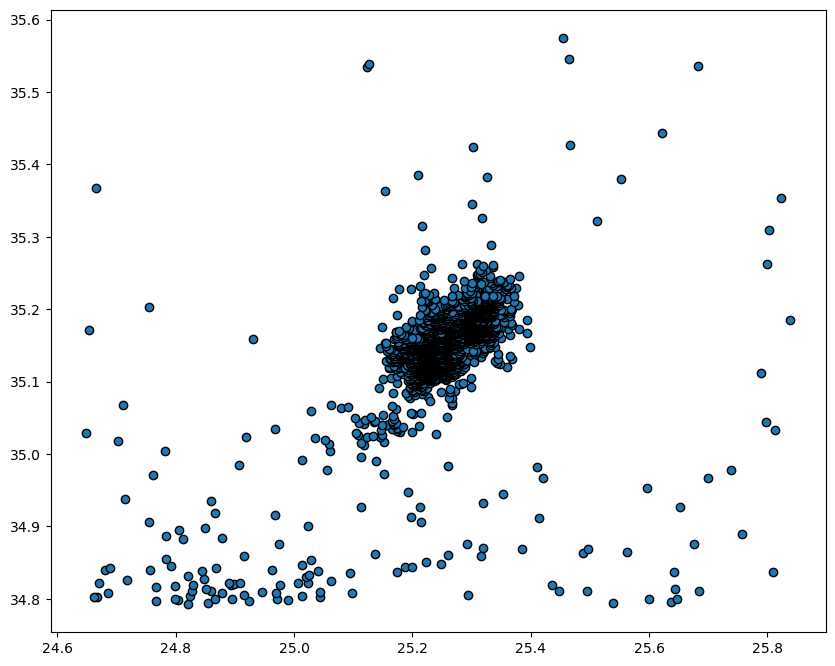

In [11]:
ax = q.plot(figsize=(10,10), edgecolor='k')

In [12]:
import contextily as cx

In [13]:
# reproject to Web Mercator, as web basemap most likely use this projection
q_wm = q.to_crs(epsg=3857)

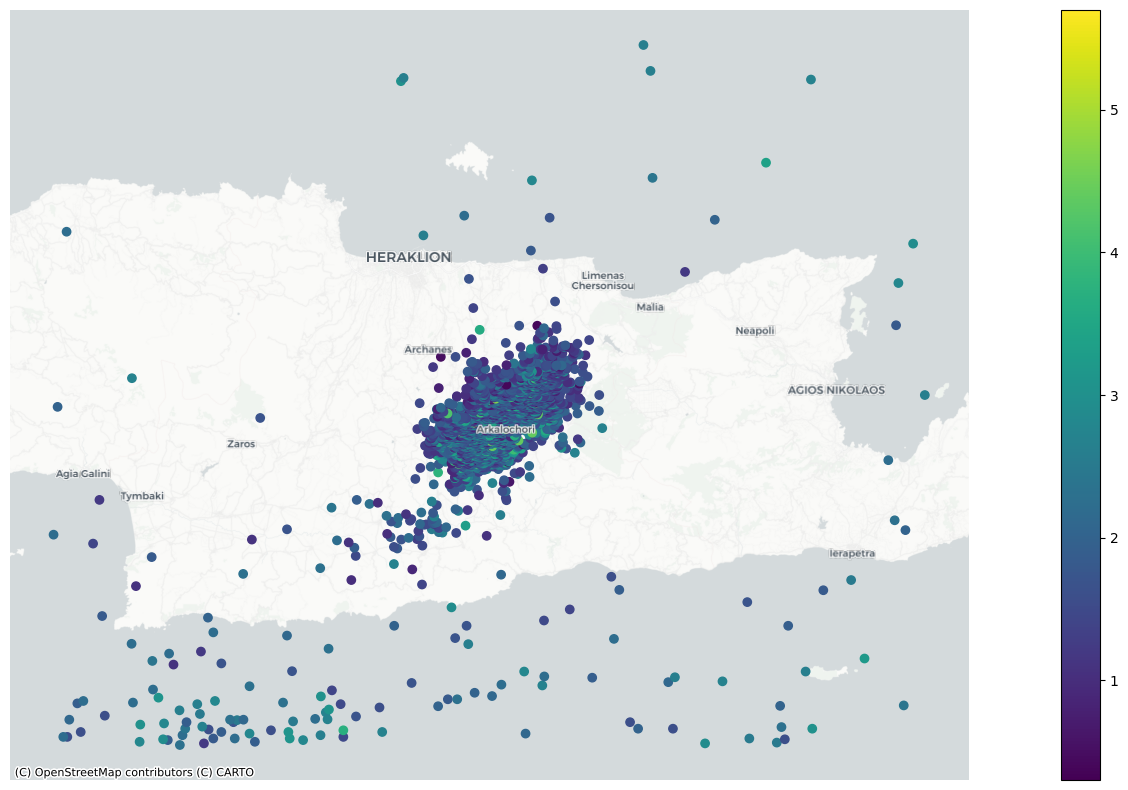

In [15]:
# plot the magnitude and add a basemap
ax = q_wm.plot(figsize=(24,10), column='MAGNITUDE(Local)', legend=True)
# basemap provider is CartoDB
cx.add_basemap(ax, zoom=12, source=cx.providers.CartoDB.PositronNoLabels)
cx.add_basemap(ax, source=cx.providers.CartoDB.PositronOnlyLabels, zoom=10)
ax.set_axis_off()

In [22]:
# download the basemap above for faster processing

# extract the boundary of earthwuakes delineated by west, south, east and north coordinates
w, s, e, n = q_wm.total_bounds

# using the above coordinates download the basemap in tif format 
_ = cx.bounds2raster(w, s, e, n,
                    ll=False,
                    path='data/heraklion_no_labels.tif',
                    source=cx.providers.CartoDB.PositronNoLabels
                    )
_ = cx.bounds2raster(w, s, e, n,
                    ll=False,
                    path='data/heraklion_only_labels.tif',
                    source=cx.providers.CartoDB.PositronOnlyLabels
                    )

In [16]:
import rasterio
from rasterio.plot import show as rioshow

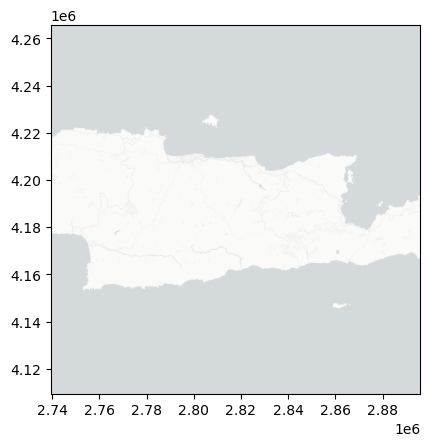

<Axes: >

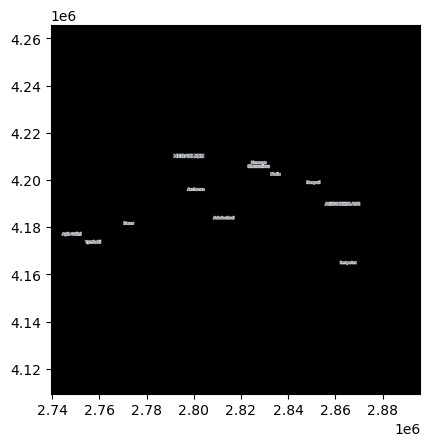

<Axes: >

In [24]:
with rasterio.open('data/heraklion_no_labels.tif') as h:
    rioshow(h)
with rasterio.open('data/heraklion_only_labels.tif') as h:
    rioshow(h)

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

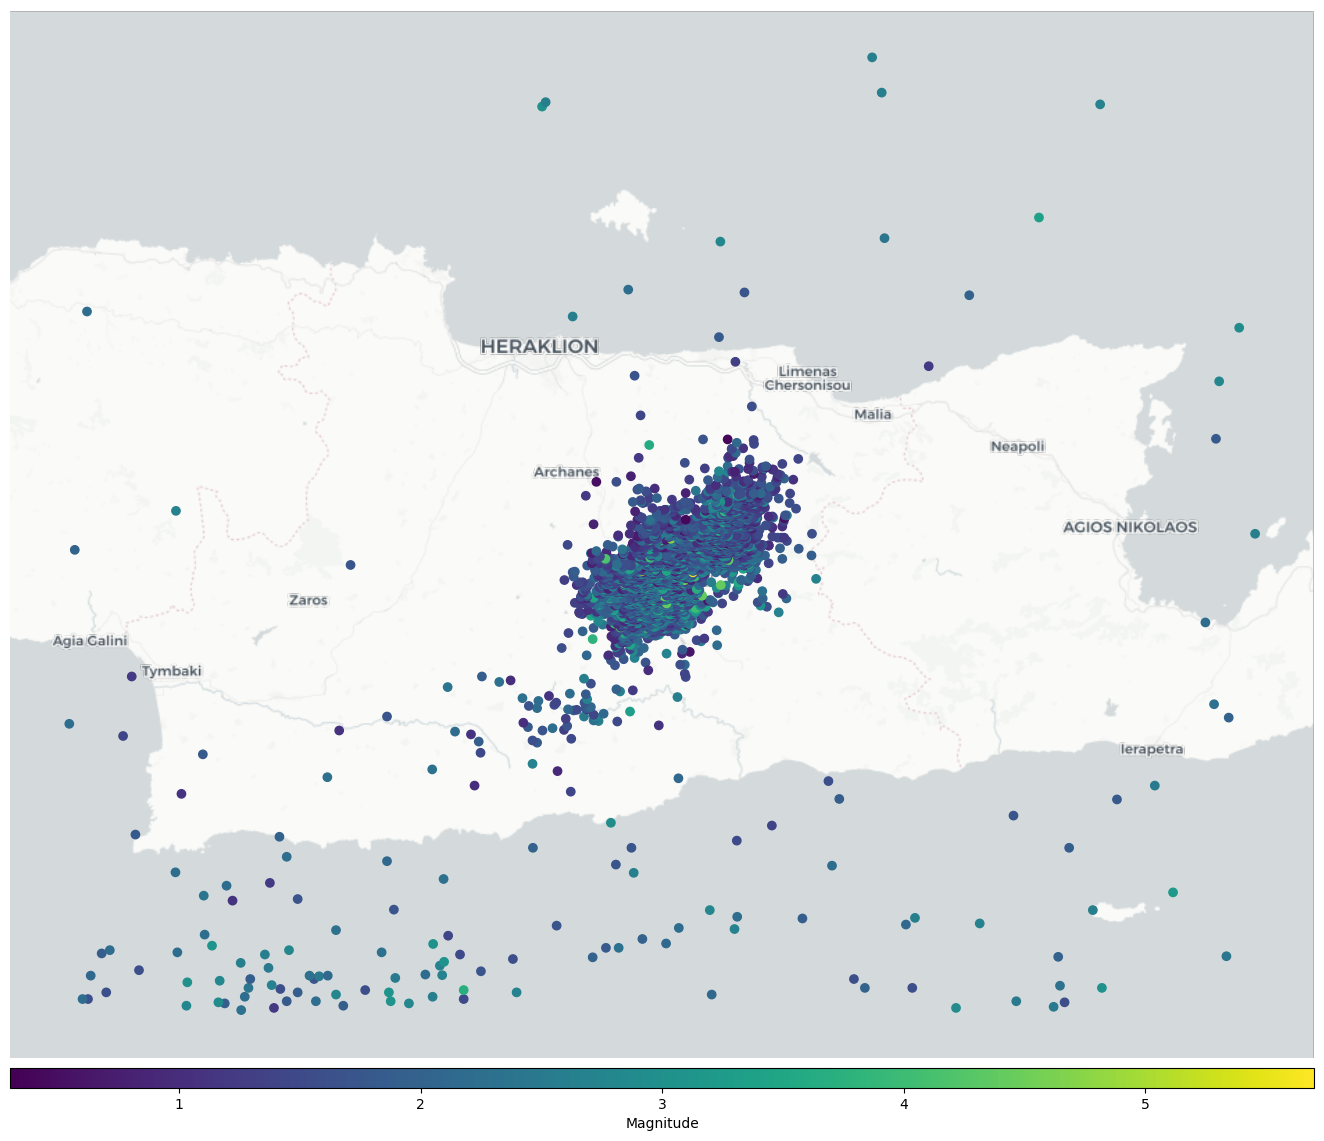

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(20,14))

divider = make_axes_locatable(ax)

cax = divider.append_axes("bottom", size=0.2, pad=0.1)

q_wm.plot(column='MAGNITUDE(Local)',
          ax=ax,
          cax=cax,
          legend=True,
          legend_kwds={"label": "Magnitude", "orientation": "horizontal"})
cx.add_basemap(ax, zoom=12, source='data/heraklion_no_labels.tif')
cx.add_basemap(ax, zoom=10, source='data/heraklion_only_labels.tif')
ax.set_axis_off();

In [16]:
# change the Date column from Object type to datetime type
q_wm['DATE'] = pd.to_datetime(q_wm['DATE'], dayfirst=True)
q_wm = q_wm.set_index('DATE')
q_wm.head()

,TIME(GMT),LAT (N),LONG (E),DEPTH(km),MAGNITUDE(Local),wkt,geometry
DATE,,,,,,,
2021-03-05,01:18:47.000000,34.8514,25.2237,22,2.0,POINT (25.2237 34.8514),POINT (2807889.440 4143705.289)
2021-12-09,21:37:14.100000,35.0789,25.2269,14,1.7,POINT (25.2269 35.0789),POINT (2808245.662 4174608.515)
2021-12-09,15:32:19.100000,35.0826,25.2159,14,2.7,POINT (25.2159 35.0826),POINT (2807021.148 4175111.827)
2021-12-09,15:55:31.200000,35.0876,25.2200,13,2.1,POINT (25.22 35.0876),POINT (2807477.558 4175792.016)
2021-12-31,23:36:34.000000,35.0880,25.2168,13,1.9,POINT (25.2168 35.088),POINT (2807121.335 4175846.432)


In [17]:
# group by month, so we can plot earthquakes per month
q_wm_grouped = q_wm.groupby(by=q_wm.index.month)
# verify that grouping is correct; count the number of events per group 
q_wm_grouped.count()

,TIME(GMT),LAT (N),LONG (E),DEPTH(km),MAGNITUDE(Local),wkt,geometry
DATE,,,,,,,
1,17,17,17,17,17,17,17
2,18,18,18,18,18,18,18
3,19,19,19,19,19,19,19
4,13,13,13,13,13,13,13
5,16,16,16,16,16,16,16
6,78,78,78,78,78,78,78
7,140,140,140,140,140,140,140
8,164,164,164,164,164,164,164
9,369,369,369,369,369,369,369


In [20]:
q_wm_grouped.get_group(1)
len(q_wm_grouped)

,TIME(GMT),LAT (N),LONG (E),DEPTH(km),MAGNITUDE(Local),wkt,geometry
DATE,,,,,,,
2021-01-12,16:10:38.200000,34.9265,25.2127,16,1.7,POINT (25.2127 34.9265),POINT (2806664.926 4153897.268)
2021-01-13,21:28:49.900000,34.9837,25.2599,18,2.1,POINT (25.2599 34.9837),POINT (2811919.205 4161666.260)
2021-01-22,17:29:49.600000,34.7946,25.5386,11,2.9,POINT (25.5386 34.7946),POINT (2842943.948 4136003.020)
2021-01-26,13:03:12.400000,34.8642,25.5624,24,2.7,POINT (25.5624 34.8642),POINT (2845593.351 4145441.746)
2021-01-16,07:39:38.900000,35.2510,25.3175,16,2.1,POINT (25.3175 35.251),POINT (2818331.208 4198043.573)
2021-01-11,22:19:40.500000,35.3801,25.5519,14,2.0,POINT (25.5519 35.3801),POINT (2844424.497 4215655.941)
2021-01-07,01:27:14.900000,34.7946,24.8538,26,1.2,POINT (24.8538 34.7946),POINT (2766712.360 4136003.020)
2021-01-28,21:58:29.800000,34.8001,24.8959,32,2.2,POINT (24.8959 34.8001),POINT (2771398.911 4136748.606)
2021-01-29,22:43:59.700000,34.8019,25.0443,33,1.5,POINT (25.0443 34.8019),POINT (2787918.723 4136992.627)


12

In [26]:
import math

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

<Axes: >

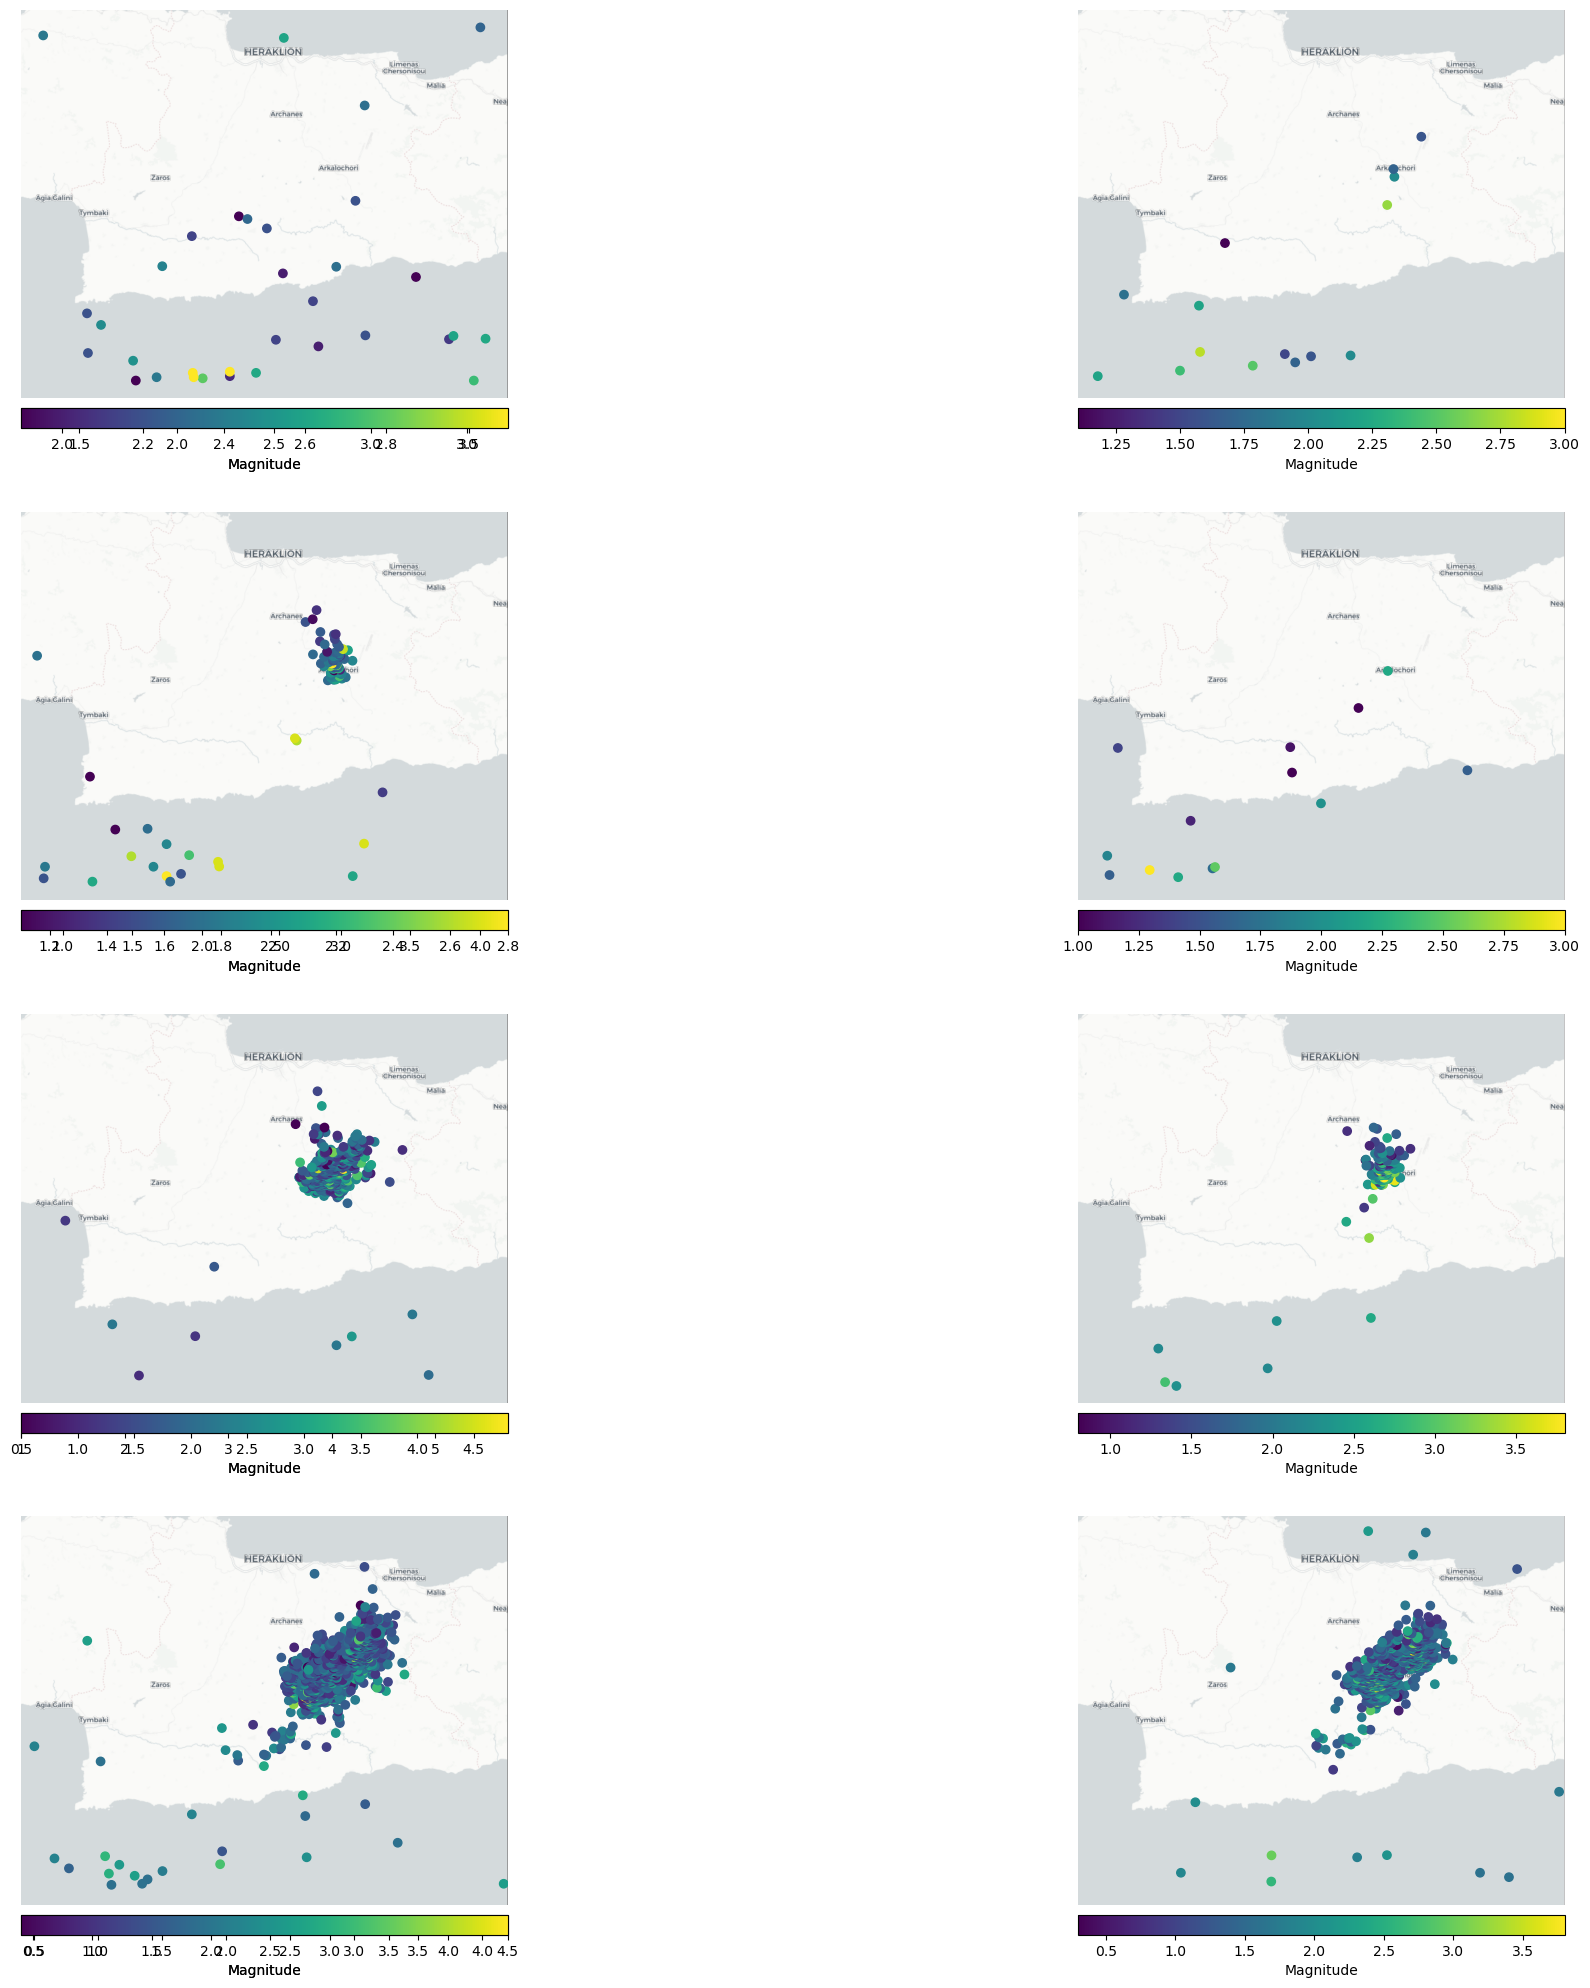

In [40]:
rows = int(math.ceil(len(q_wm_grouped) / 3))
cols = int(math.ceil(len(q_wm_grouped) / 6))

fig = plt.figure(figsize=(25, 25))
# , layout='constrained'
axes = fig.subplots(rows, cols, sharex='all', sharey='all' )

m = 1
row, col = 0, 0

while m <= len(q_wm_grouped):
    divider = make_axes_locatable(axes[row, col])
    cax = divider.append_axes("bottom", size=0.2, pad=0.1)
    
    q_wm_grouped.get_group(m).plot(column='MAGNITUDE(Local)',
                                   ax=axes[row, col],
                                   cax=cax,
                                   legend=True,
                                   legend_kwds={"label": "Magnitude", "orientation": "horizontal"})
    cx.add_basemap(axes[row, col], zoom=10, source='data/heraklion_no_labels.tif')
    cx.add_basemap(axes[row, col], zoom=10, source='data/heraklion_only_labels.tif')
    axes[row, col].set_axis_off()
    m += 1
    col += 1
    if m % 3 == 1:
        row += 1
        col = 0
    elif row == rows:
        row = 0
    elif col == cols:
        col = 0